# NMF on images

In [44]:
import logging
import numpy as np
import pandas as pd
from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from sklearn.metrics import pairwise_distances

from os import listdir,getcwd
from os.path import isfile, join
from PIL import Image, ImageOps
import os 

We'll design an algorithm that can detect similarity in images usinf NMF. One strength of NMF is that the intermediate representation can be interpreted as an image, so this is very good when an interpretable model is needed.

For this we'll use the [Anime Face Dataset from Kaggle](https://www.kaggle.com/datasets/splcher/animefacedataset)

In [55]:
## HELPER FUNCTIONS
def get_data_matrix(test=False, l=100, w=100, mypath="data/images/"):

    files = [join(mypath,f) for f in listdir(mypath) if isfile(join(mypath, f)) and f[0] != '.']
  
    if test:
        print("test data")
        files=files[9000:10000]
        
    else:
        print("training data")
        files=files[0:9000]
        
    print(len(files))
    X = np.zeros((len(files),l*w))
    for i,file in enumerate(files):
        img = Image.open(file).resize((w, l))
        img = ImageOps.grayscale(img)

        I=np.array(img)
 
        X[i,:]=I.reshape(1,-1)
    return X

def reshape_row(x, l, w) :
    plt.imshow(x.reshape(l, w),cmap="gray")
    
def threshold(similar_index, similar_distance, max_ = 0.1, min_ = 0):
    dataset_index = np.where(np.logical_and(similar_distance>min_ ,similar_distance<max_))[0]
    query_index = similar_index[np.logical_and(similar_distance>min_ ,similar_distance<max_)]
    return dataset_index,query_index

def plot_data_query(X, X_q, dataset_index, query_index, N, l, w):
    for data_sample,query_sample in zip(dataset_index[0:N],query_index[0:N]):

        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        reshape_row(X[data_sample], l, w)
        plt.title("dataset sample {}".format(data_sample))
        plt.subplot(1,2,2)
        reshape_row(X_q[query_sample], l, w)
        plt.title("query sample match {}".format(query_sample))
        plt.show()

        print("-----------------------------------------------------")

Below we read all the face images into a dataset of size (9000, 10000), where all images are resized to a 100x100 image. So we can see that there are 9000 images total, which have been reshaped to singel dimensional feature vectors of 100000 components.

In [24]:
l, w = 100, 100
X = get_data_matrix(test=False, l=100, w=100)
X.shape

training data
9000


(9000, 10000)

We want to reduce this to 10 intermediary components using NMF. After the fit has finished we can get the components matrix (of shape (n_components, n_pixels))

In [25]:
n_components = 10

nmf_estimator = NMF(n_components=n_components, tol=5e-3, max_iter=2000)
nmf_estimator.fit(X) 
H = nmf_estimator.components_
H.shape

(10, 10000)

For each row in this matrix, we can reshape the row back to a 100x100 grid, which will result in an image we can display.

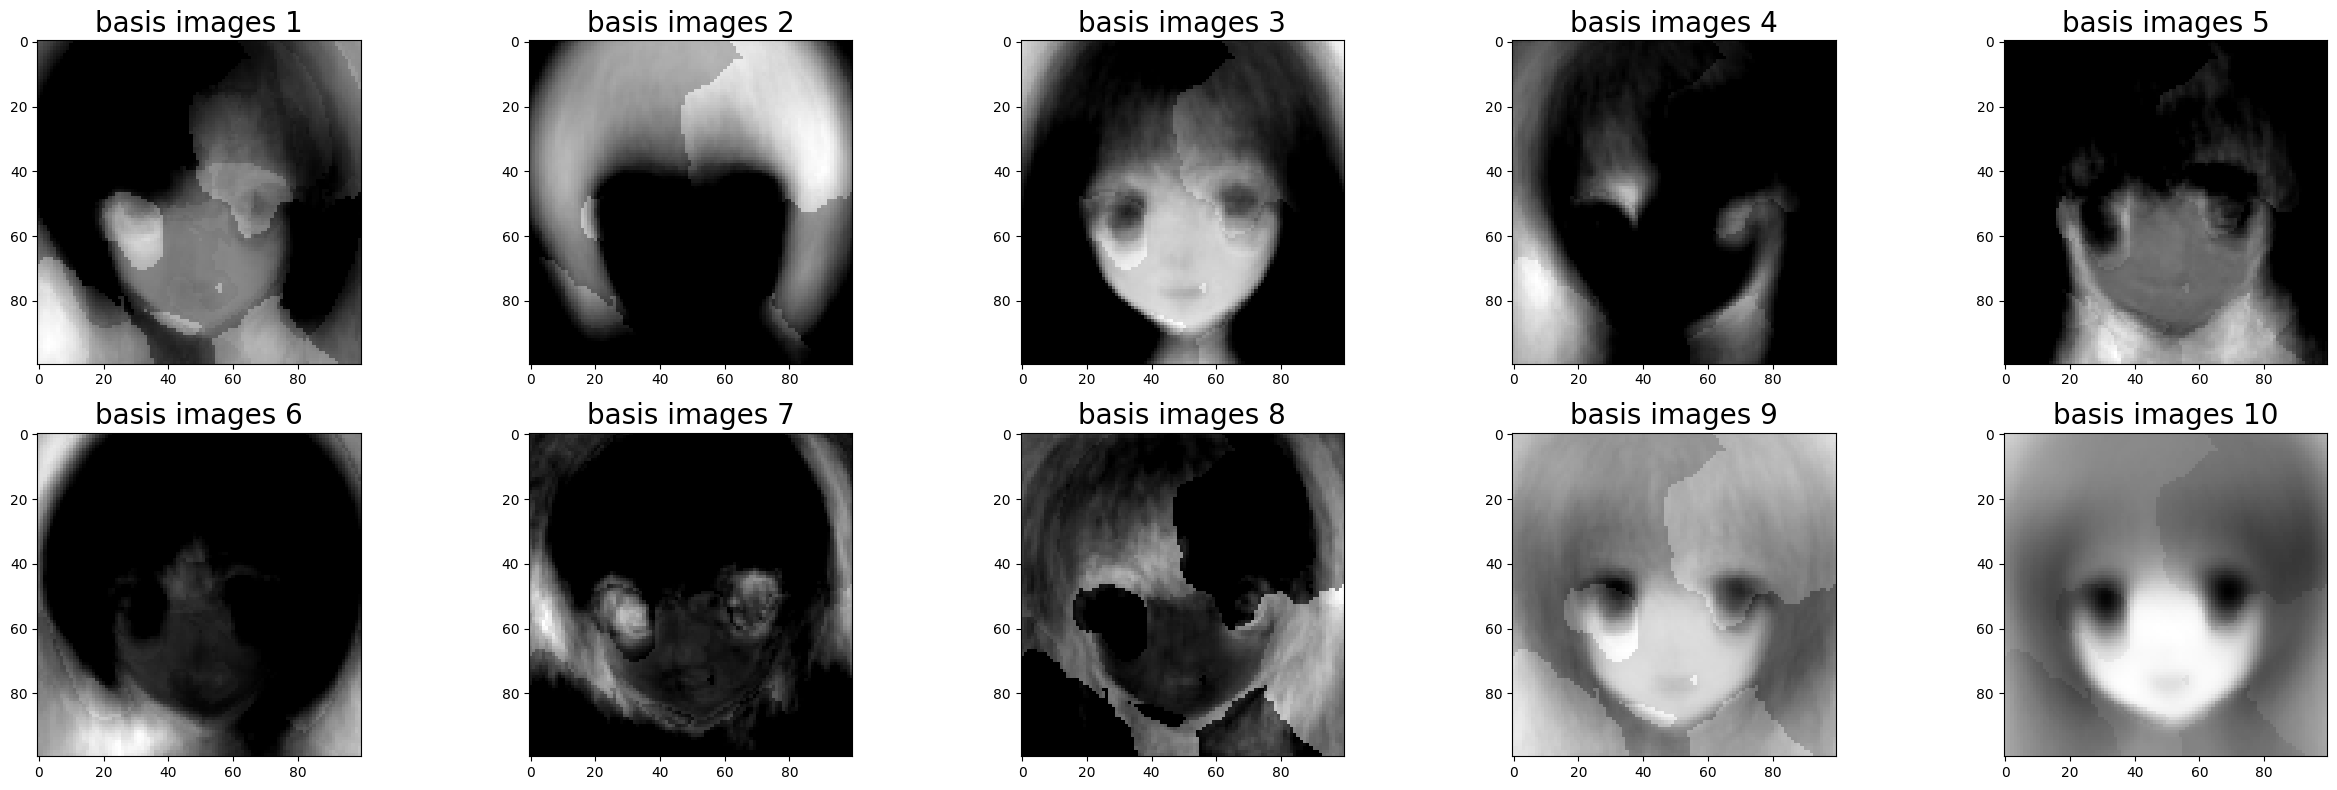

In [26]:
plt.figure(figsize=(25, 8))

for i, h in enumerate(H):   
    plt.subplot(2, 5, i+1)
    reshape_row(h, l, w)
    plt.title("basis images {}".format(str(i+1)), fontsize=20) 
    
plt.tight_layout()

We can also get the weight matrix for our dataset by transforming the data using our NMF estimator. As expected, this has a dimension of (n_samples, n_components). This matrix encodes the projection of each image onto the 10 basis elements in the components matrix.

In [27]:
W = nmf_estimator.transform(X)
W.shape

(9000, 10)

Text(0.5, 1.0, 'encodings for image 1 ')

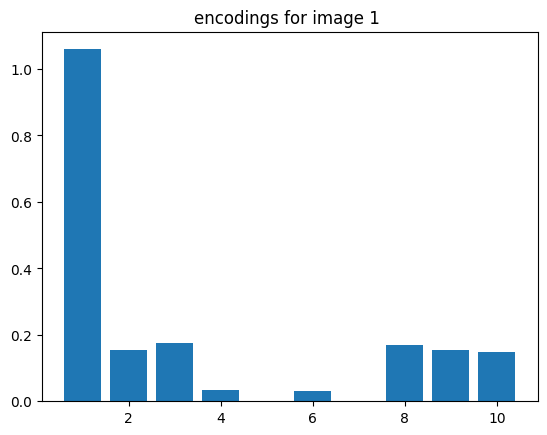

In [28]:
i = 0
w_i = W[i,:]

plt.bar([n+1 for n in range(len(w_i))],w_i)
plt.title("encodings for image {} ".format (i+1))

So the first component weight is largest, which means it will likely be close to the original image. The other components have very low weights and will be dissimilar.

Text(0.5, 1.0, 'Dissimilar basis 9')

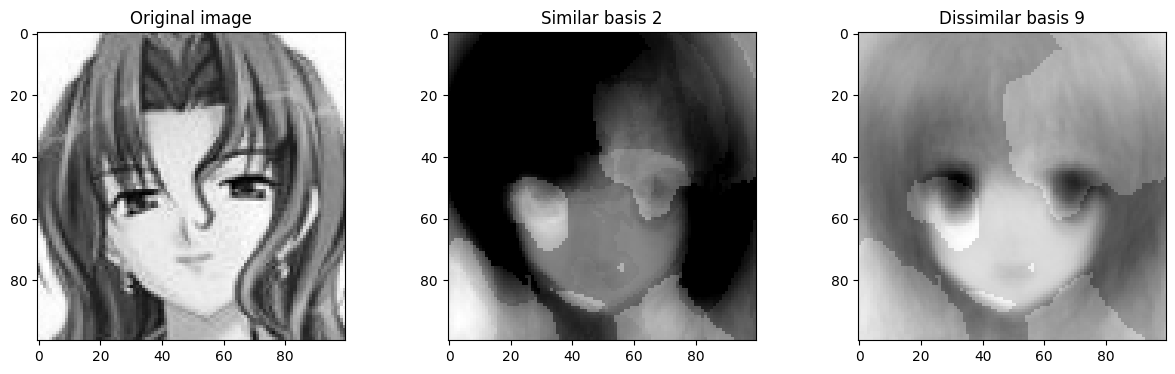

In [33]:
plt.figure(figsize=(15,4))

plt.subplot(131)
reshape_row(X[0,:], l, w)
plt.title("Original image")

plt.subplot(132)
reshape_row(H[0,:], l, w)
plt.title("Similar basis 2")

plt.subplot(133)
reshape_row(H[8,:], l, w)
plt.title("Dissimilar basis 9")

Trying to reconstruct the images from the NMF representation is easy:

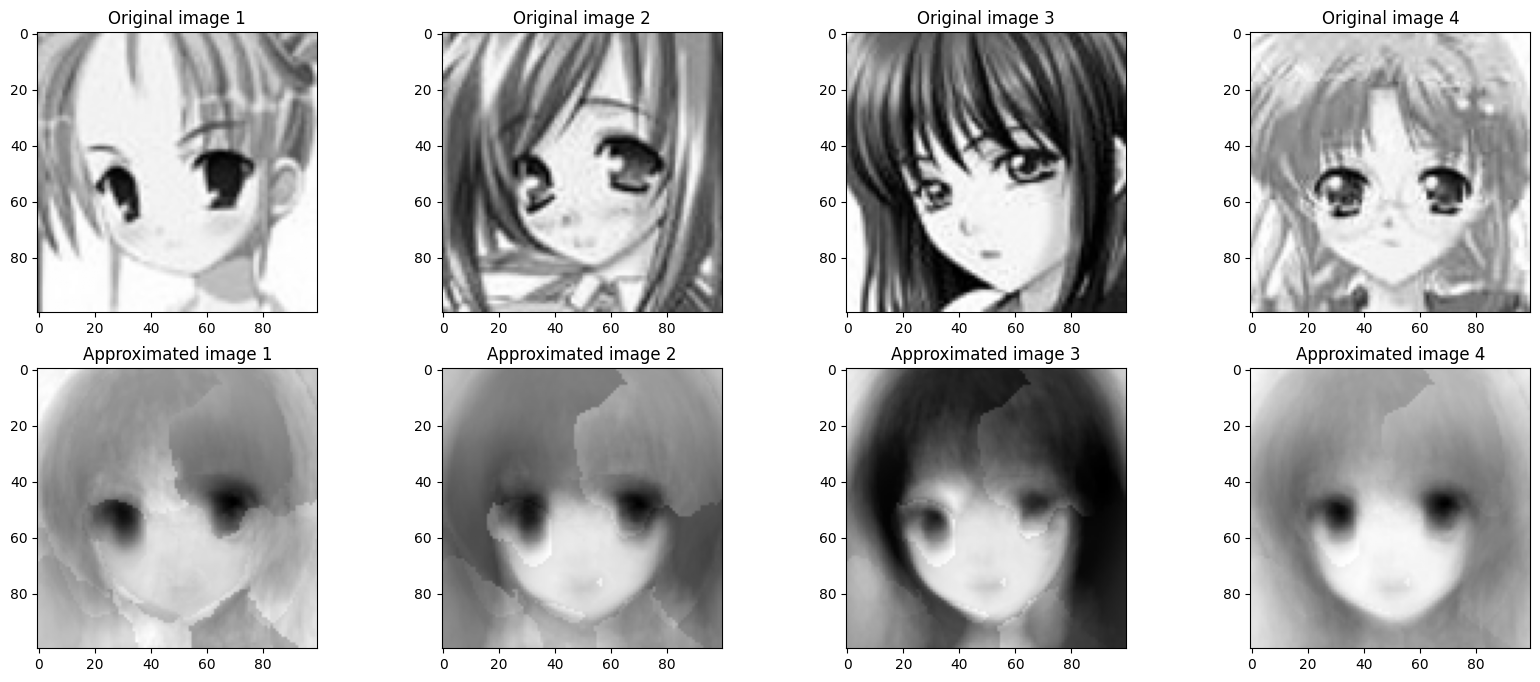

In [32]:
Xhat = nmf_estimator.inverse_transform(W)

plt.figure(figsize=(20,8))

for i in range(1,5):
    plt.subplot(2,4,i)
    reshape_row(X[i], l, w)
    plt.title(f"Original image {i}")
    
    plt.subplot(2,4,i+4)
    reshape_row(Xhat[i], l, w)
    plt.title(f"Approximated image {i}")

In [34]:
Xhat_M=W@H

In [35]:
Xhat[0,:10], Xhat_M[0,:10]

(array([259.72502452, 254.41996129, 248.50084208, 246.76800947,
        244.18073194, 239.80939949, 232.39326532, 228.8136294 ,
        223.25572699, 214.88677646]),
 array([259.72502452, 254.41996129, 248.50084208, 246.76800947,
        244.18073194, 239.80939949, 232.39326532, 228.8136294 ,
        223.25572699, 214.88677646]))

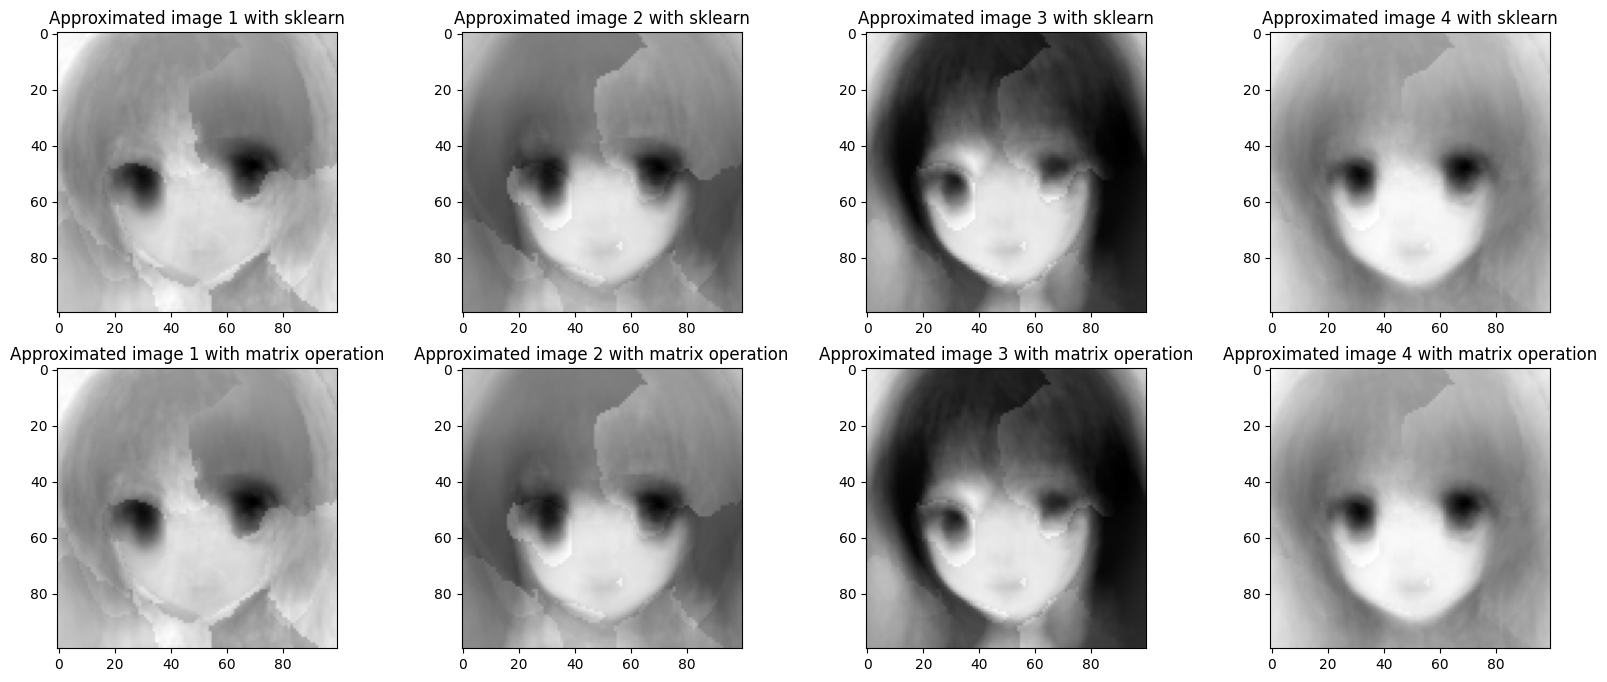

In [37]:
plt.figure(figsize=(20,8))

for i in range(1,5):
    plt.subplot(2,4,i)
    reshape_row(Xhat[i], l, w)
    plt.title(f"Approximated image {i} with sklearn")
    
    plt.subplot(2,4,i+4)
    reshape_row(Xhat_M[i], l, w)
    plt.title(f"Approximated image {i} with matrix operation")

The successive approximation of an image by components is shown below:

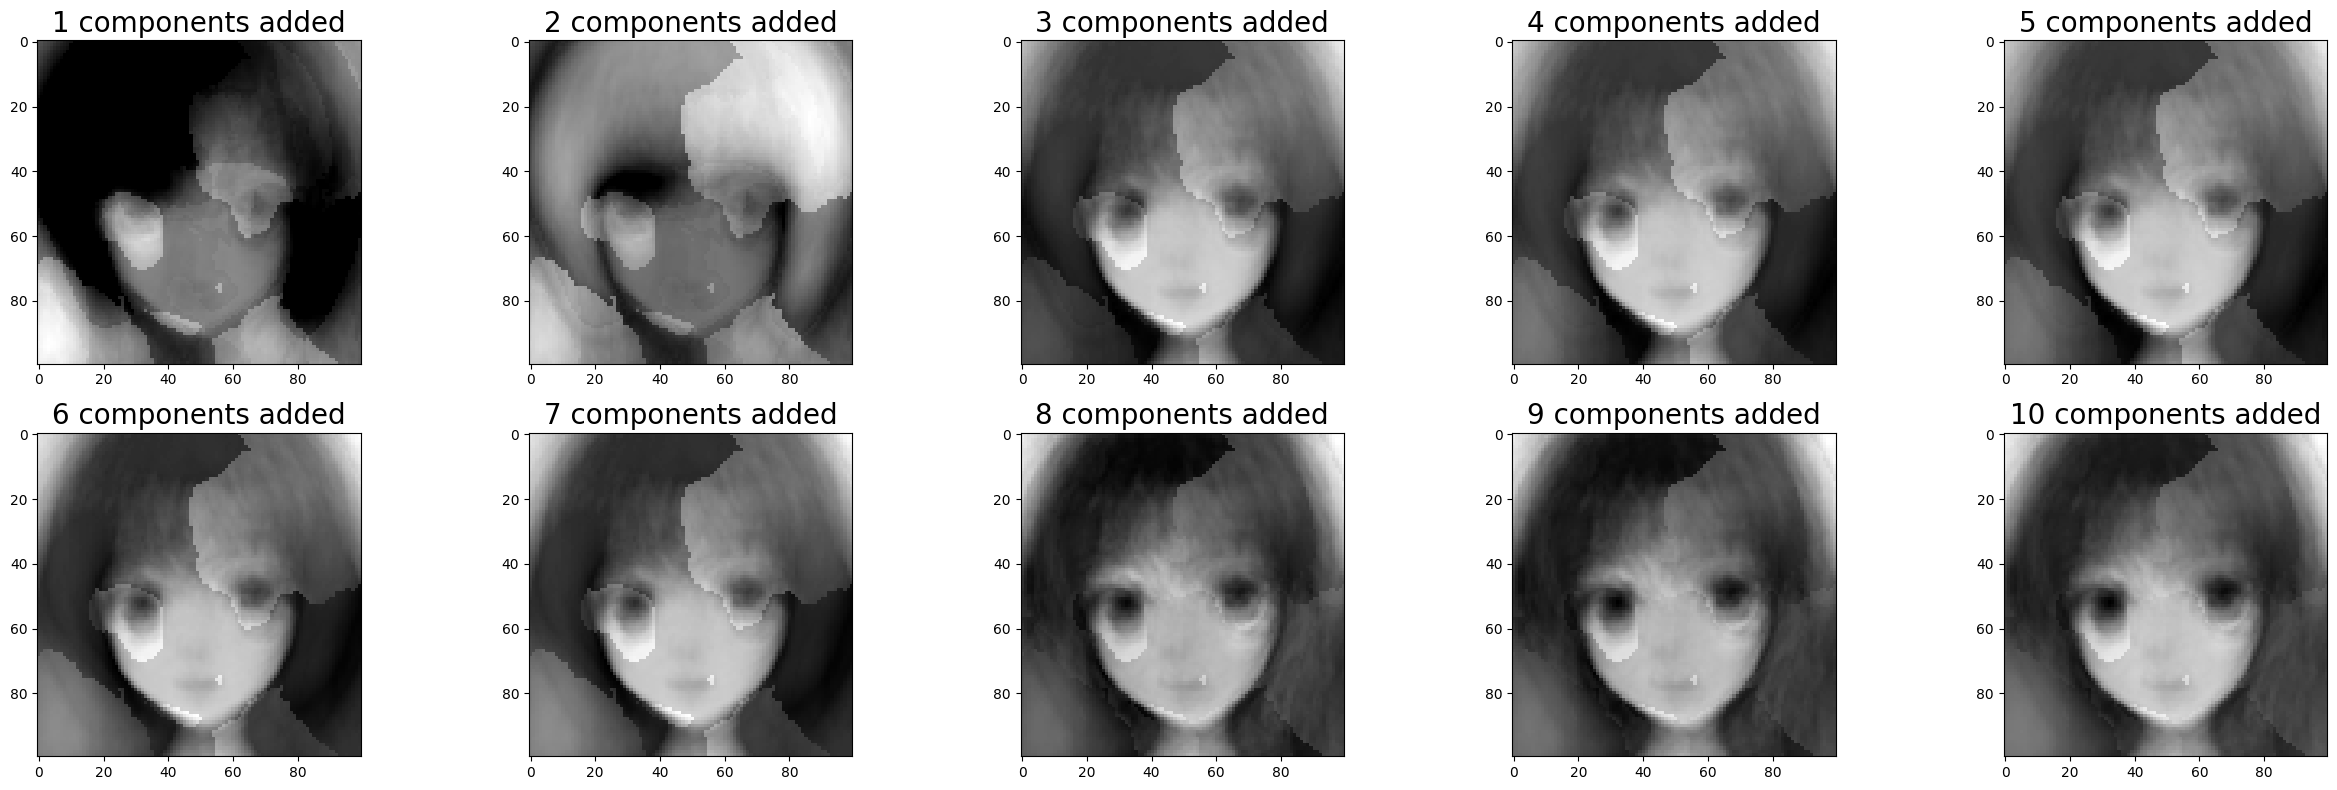

In [39]:
# initialize an image array with 10000 zeros which will be reshaped as 100x100  
image=np.zeros((1,10000))

plt.figure(figsize=(25,8))
for i, (w_, h) in enumerate(zip(w_i, H)):
    
    # w is the encoding vector of the first image in X
    # reconstruction of the image is a linear combination of H 
    plt.subplot(2,5,i+1)
    image += w_*h
    reshape_row(image, l, w)
    plt.title(f"{i+1} components added", fontsize=20)
plt.tight_layout()

## Image Retrieval

First we build a test dataset. This dataset would be the real images we could try to compare against when trying to find copyright infringement.

In [42]:
X_q = get_data_matrix(test=True, l=100, w=100)
X_q.shape

test data
1000


(1000, 10000)

First we calculate the embeddings of the new images in our intermediate components space.

In [43]:
W_q = nmf_estimator.transform(X_q)
W_q.shape

(1000, 10)

We then define the distance matrix, containing the pairwise distance between the query dataset and the original dataset. In this case se'll get a 9000x1000 matrix.

In [45]:
D = pairwise_distances(W, W_q, metric='cosine')
D.shape

(9000, 1000)

Now we can look at the largest magnitude values in this matrix, which will indicate high similarity between query image $X_q^i$ and dataset image $X_d^j$. This will give a vector of indices, one for each of the dataset images, which query image is most similar.

In [47]:
similar_index = np.argmin(D, axis=1)
similar_index.shape

(9000,)

And we'll get the actual distance value

In [48]:
similar_distance = np.min(D, axis=1)
similar_index.shape

(9000,)

Plotting this in a histogram below, we see that most of the images are not similar at all.

Text(0.5, 1.0, 'Distance values')

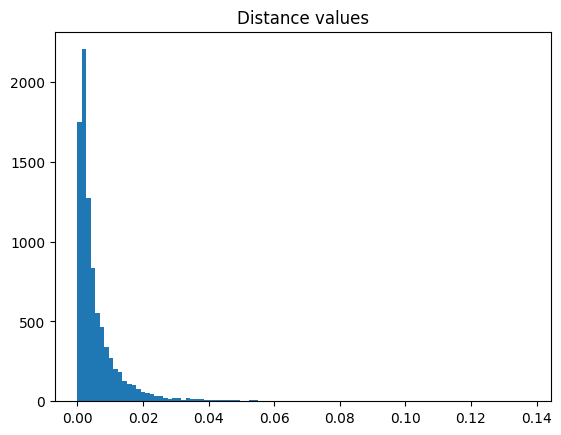

In [49]:
plt.hist(similar_distance, bins=100)
plt.title("Distance values")

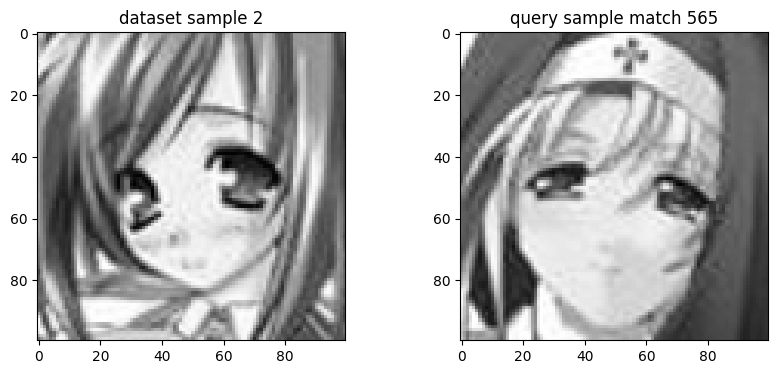

-----------------------------------------------------


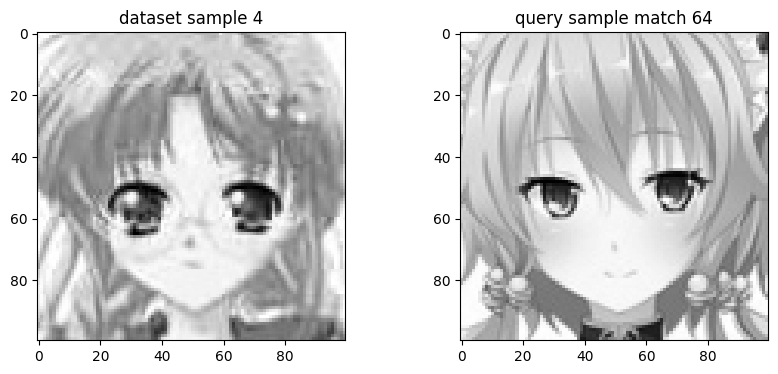

-----------------------------------------------------


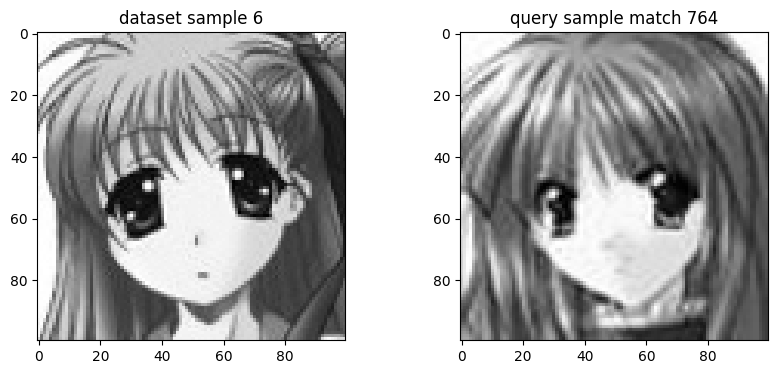

-----------------------------------------------------


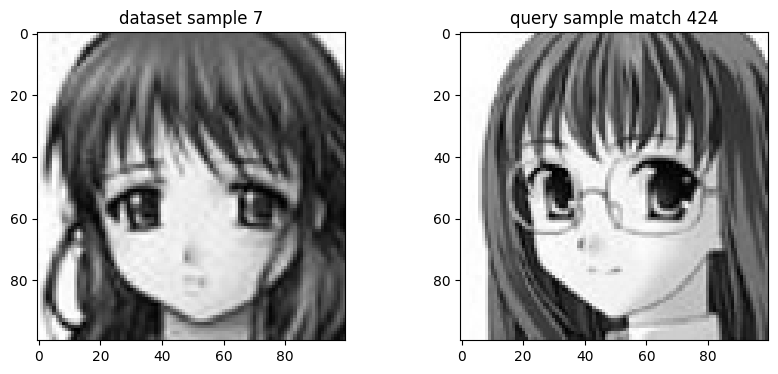

-----------------------------------------------------


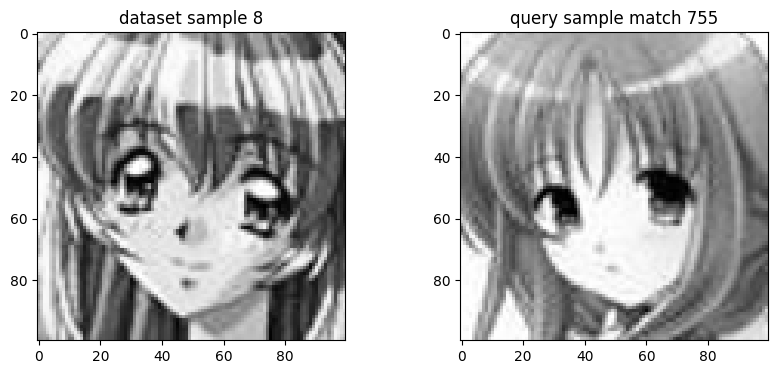

-----------------------------------------------------


In [56]:
dataset_index, query_index = threshold(similar_index, similar_distance, max_=0.005, min_=0.00001)
plot_data_query(X, X_q, dataset_index, query_index, 5, l, w)

## Olivetti Faces

We can apply this principle to another dataset of faces: [Sklearn - Olivetti Faces](https://scikit-learn.org/stable/datasets/real_world.html#olivetti-faces-dataset)

In [58]:
from sklearn.datasets import fetch_olivetti_faces

rng = RandomState(0)
data = fetch_olivetti_faces(shuffle=True, random_state=rng, data_home="./data")
X = data.images

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to ./data


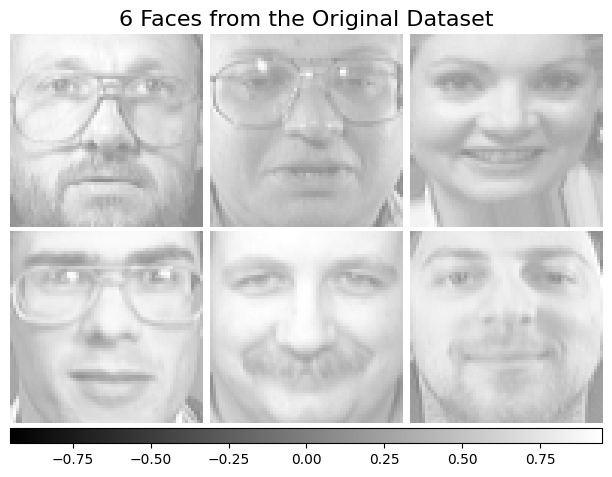

In [59]:
image_shape = (64, 64)

def plot_faces(title, images, n_col, n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows = n_row,
        ncols = n_col,
        figsize = (2.0*n_col, 2.3*n_row),
        facecolor='white',
        constrained_layout=True)
    
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax)
        ax.axis('off')
    
    fig.colorbar(im, ax=axs, orientation='horizontal', shrink=0.99, 
                aspect=40, pad=0.01)
    plt.show()
    
plot_faces("6 Faces from the Original Dataset", X[:6], 3, 2)

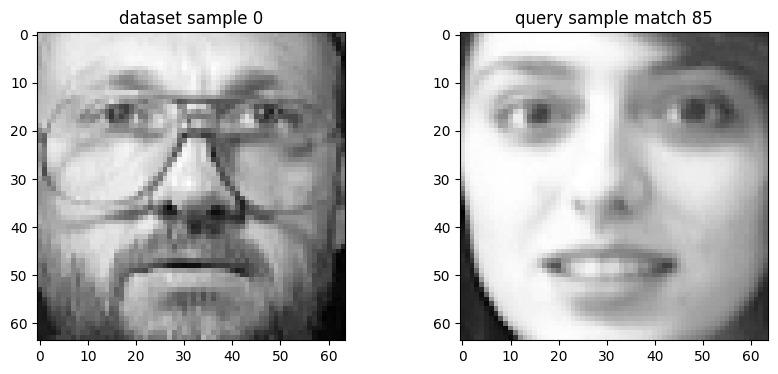

-----------------------------------------------------


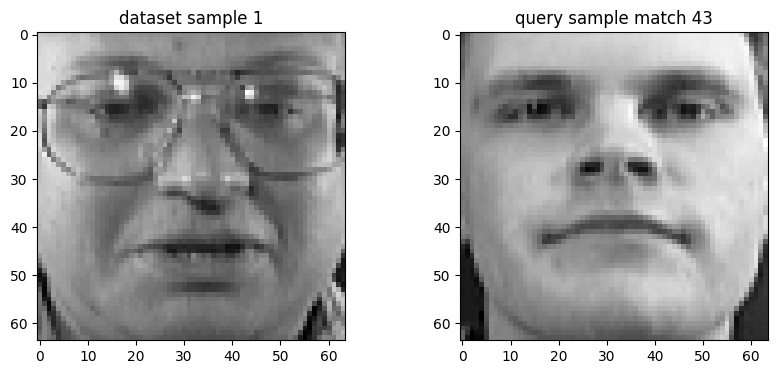

-----------------------------------------------------


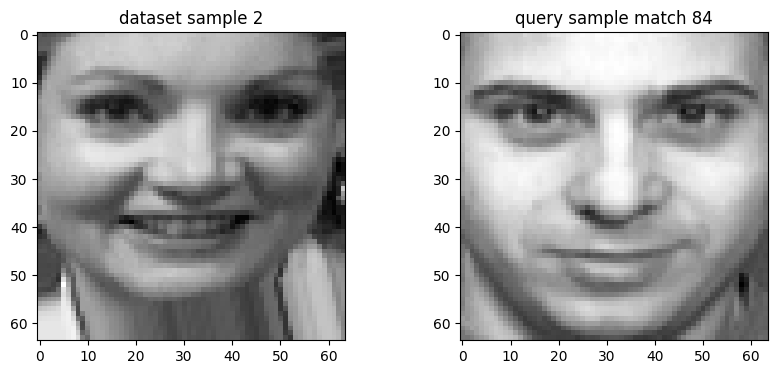

-----------------------------------------------------


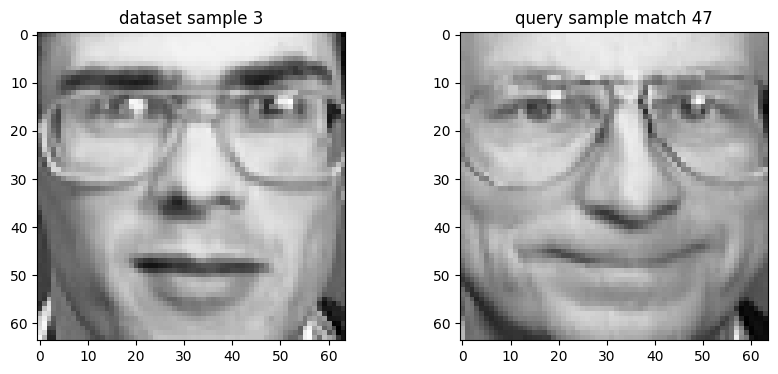

-----------------------------------------------------


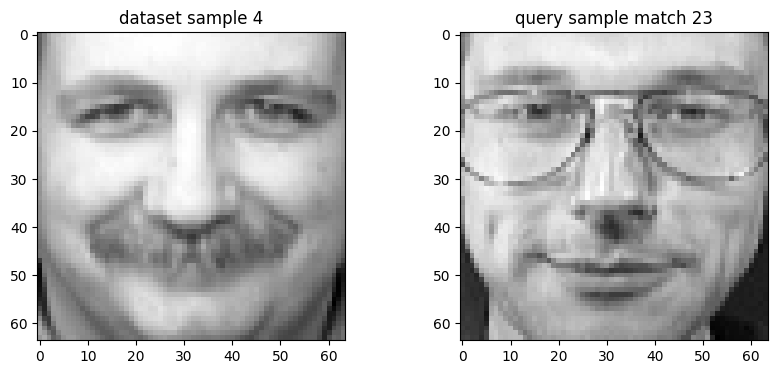

-----------------------------------------------------


In [61]:
X_r = X[:300].reshape((300, 64*64))
X_q = X[300:].reshape((100, 64*64))

nmf = NMF(n_components=10, tol=5e-3,max_iter=2000)
X_r_W = nmf.fit_transform(X_r)
X_q_W = nmf.fit_transform(X_q)

D = pairwise_distances(X_r_W, X_q_W, metric='cosine')

similar_index = np.argmin(D, axis=1)
similar_distance = np.min(D, axis=1)

o_index, q_index = threshold(similar_index, similar_distance)

l = 64
w = 64
plot_data_query(X_r, X_q, o_index, q_index, 5, l, w)